In [1]:
import pandas as pd
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))

Using TensorFlow backend.


['best-artworks-of-all-time', 'wikiart', 'vgg19', 'image-classification']


In [2]:
StylePath = '/kaggle/input/wikiart/Cubism'
ContentPath = '../input/image-classification/validation/validation/travel and adventure/'

In [3]:
base_image_path = ContentPath+'13.jpg'
style_image_path = StylePath+'/auguste-herbin_composition.jpg'

In [4]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [5]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

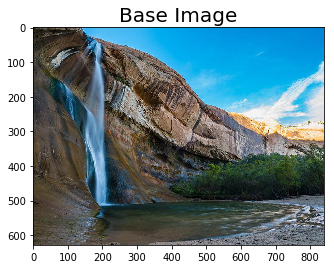

In [6]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'13.jpg')
plt.imshow(img1)

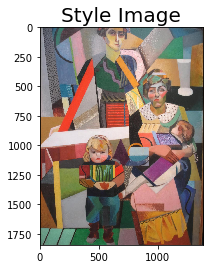

In [7]:
plt.figure()
plt.title("Style Image",fontsize=20)
#img1 = load_img(StylePath+'Pablo_Picasso/Pablo_Picasso_92.jpg')
img1 = load_img(StylePath+"/auguste-herbin_composition.jpg")
plt.imshow(img1)

In [8]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
K.image_data_format()

'channels_last'

In [10]:
# contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [11]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

#### Building the VGG19 model

In [12]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights

from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


In [13]:
# Content layer 
content_layers = ['block5_conv2'] 

# Style layer 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 33, 512), dtype=float32)


In [15]:
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [16]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    

In [17]:
content_weight=0.025 
style_weight=1.0

loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 33, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 33, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 33, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 535, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 535, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 535, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 267, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 267, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 267, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 133, 256), 

In [18]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [19]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 535, 3) dtype=float32>]

In [20]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [21]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [22]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [23]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [24]:
evaluator = Evaluator()

In [25]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 1.6201596e+21
Start of iteration 1
Current loss value: 9.414188e+20
Start of iteration 2
Current loss value: 6.7096654e+20
Start of iteration 3
Current loss value: 4.8722323e+20
Start of iteration 4
Current loss value: 3.792138e+20
Start of iteration 5
Current loss value: 3.127865e+20
Start of iteration 6
Current loss value: 2.7064512e+20
Start of iteration 7
Current loss value: 2.3903736e+20
Start of iteration 8
Current loss value: 2.0818767e+20
Start of iteration 9
Current loss value: 1.8737613e+20
Start of iteration 10
Current loss value: 1.7221406e+20
Start of iteration 11
Current loss value: 1.5611579e+20
Start of iteration 12
Current loss value: 1.4429944e+20
Start of iteration 13
Current loss value: 1.3501657e+20
Start of iteration 14
Current loss value: 1.2723676e+20
Start of iteration 15
Current loss value: 1.2060002e+20
Start of iteration 16
Current loss value: 1.14640984e+20
Start of iteration 17
Current loss value: 1.0901774e+20
Star

**The Final Image**

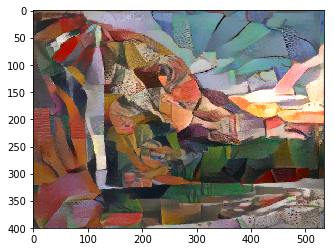

In [27]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

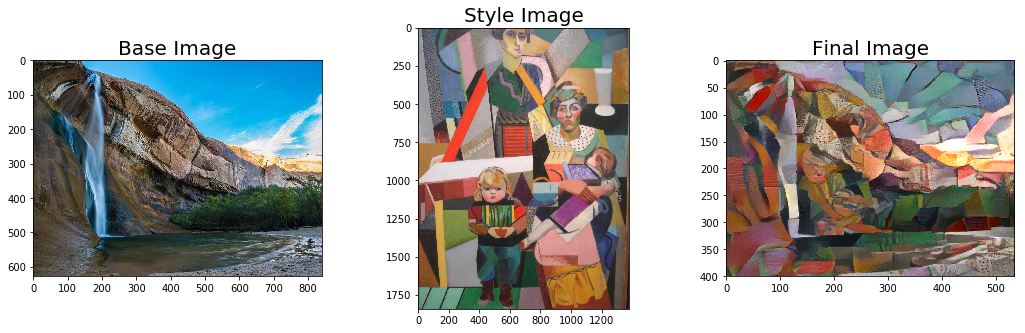

In [28]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)